In [116]:
import MPPIController
import numpy as np
import time
import matplotlib.pyplot as plt
from time import perf_counter
from scipy.integrate import odeint
import os
from pathlib import Path
import sys
sys.path.append("..")

plt.style.use(["science", "grid"])

In [117]:
import tensorflow as tf

# Inverted pendulum
Try MPPI controller with neural network dynamics model on an inverted pendulum.

In [118]:
# Get neural network model loaded
model_path = Path(os.getcwd()).parent / "neural_networks" / "inverted_pendulum" / "models"
availible_models = [x for x in model_path.iterdir() if x.is_dir()]

for (i, model_name) in enumerate(availible_models):
    print("[{}]  {}".format(i, model_name))

idx = int(input("Select which model number to load: "))
nn_model = tf.keras.models.load_model(availible_models[idx])

[0]  /Users/micahreich/Documents/16711-final-project/neural_networks/inverted_pendulum/models/inverted_pendulum_model_16nodes_18-04-2023 04:50:54
[1]  /Users/micahreich/Documents/16711-final-project/neural_networks/inverted_pendulum/models/inverted_pendulum_model_16nodes_20-04-2023 02:54:16
Select which model number to load: 1


In [119]:
class InvertedPendulum:
    def __init__(self, initial_state, m, l, b, g, dt):
        self.initial_state = initial_state
        self.desired_state = None
        self.m = m
        self.l = l
        self.b = b
        self.g = g
        self.dt = dt
        self.nx, self.nu = (2, 1)
        self.NULL_ACTION  = np.zeros(self.nu)
                        
        self.controller = MPPIController.MPPIController(
            n_rollouts=200,
            horizon_length=10,
            exploration_cov=np.diag([1.5 ** 2]),
            exploration_lambda=1e-3,
            nx=self.nx,
            nu=self.nu,
            terminal_cost=self.terminal_cost,
            state_cost=self.state_cost,
            evolve_state=self.evolve_state,
            dt=dt,
            control_range={"min": np.array([-10]), "max": np.array([10])},
            control_noise_initialization = MPPIController.ControlNoiseInit.LAST,
            nn_dynamics = True
        )
        
        self.measurement_noise_cov = np.array([
            [(3 * np.pi / 180) ** 2]  # 5 degrees of measurement noise
        ])
    
    @staticmethod
    def transform_angle_error(error):
        e_theta, e_omega = error
        if e_theta > np.pi:
            return np.aray([2 * np.pi - error, e_omega])
        elif e_theta < -np.pi:
            return np.aray([-2 * np.pi - error, e_omgea])
        return error
    
    def terminal_cost(self, x):
#         error = InvertedPendulum.transform_angle_error((self.desired_state - x))
        error = self.desired_state - x
            
        Q = np.diag([1, 1])
        
        return error.T @ Q @ error

    def state_cost(self, x):
#         error = InvertedPendulum.transform_angle_error((self.desired_state - x))
        error = self.desired_state - x
        Q = np.diag([3, 1])
        
        return error.T @ Q @ error

    def evolve_state(self, nn_input):
        states, actions = nn_input[:, :self.nx], nn_input[:, self.nx:]
        xs, xdots = states[:, :(self.nx // 2)], states[:, (self.nx // 2):]
        
        xddots = nn_model(nn_input).numpy()
                
        next_xs = xs + self.dt * xdots + (1/2 * self.dt ** 2 * xddots)
        next_xdots = xdots + self.dt * xddots
        
        next_xs %= (2 * np.pi)
        
        return np.hstack((next_xs, next_xdots))
    
    def simulator(self, x, u, measurement_noise=False):
        def dynamics(u):
            def dydt(y, t):
                theta, omega = y
                alpha = (-self.b * omega + u[0] + self.m * self.g * self.l * np.sin(theta)) / (self.m * self.l**2)

                return np.array([omega, alpha])
            return dydt
        
        dynamics_ode = dynamics(u)
        next_state = odeint(dynamics_ode, x, np.array([0, self.dt]))[1]
        
        if measurement_noise:
            noise = np.random.multivariate_normal(np.zeros_like(u), cov=self.measurement_noise_cov,
                                                  size=1)[0]
            next_state += noise
        
        return next_state

In [120]:
dt = 1 / 10

inv_pend_env = InvertedPendulum(
    initial_state=np.array([0, 0]),
    m=1,     # kg
    l=1,     # m
    b=0.1,   # ?
    g=-9.81, # m / s^2
    dt=dt    # s
)

inv_pend_env.desired_state = np.array([np.radians(180), 0])

## Neural Network vs. Ground Truth (Natural Dynamics)
Test the neural network dynamics model with the natural dynamics of the system before using it in the controller

In [121]:
# Test the neural network dynamics on the system's natural dynamics

initial_state = np.array([0, 0.5])

nn_current_state = initial_state
truth_current_state = initial_state
action = np.array([0])

simulation_length = 5
n_steps = int((1 / dt) * simulation_length)

# Simulate the ground truth pendulum

def dydt(y, t):
    m, l, b, g = inv_pend_env.m, inv_pend_env.l, inv_pend_env.b, inv_pend_env.g
    theta, omega = y
    alpha = (-b * omega + m * g * l * np.sin(theta)) / (m * l**2)

    return np.array([omega, alpha])
        
truth_states = odeint(dydt, truth_current_state,
                      np.linspace(0, simulation_length, int(simulation_length/dt)))
truth_states[:, 0] %= (2*np.pi)

# Simulate the neural network pendulum
nn_states = np.empty((n_steps, 2))

for i in range(n_steps):
    nn_states[i] = nn_current_state
    
    nn_input = np.hstack((nn_current_state, action)).reshape(1, -1)
    nn_current_state = inv_pend_env.evolve_state(nn_input)[0]

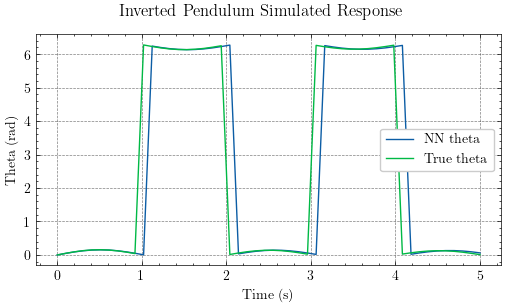

In [122]:
# Plot the simulated response

time = np.linspace(0, simulation_length, n_steps)

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
fig.suptitle("Inverted Pendulum Simulated Response")

ax.plot(time, nn_states[:, 0], label="NN theta")
ax.plot(time, truth_states[:, 0], label="True theta")
# ax.plot(time, truth_states[:, 1], label="True omega")


ax.set(xlabel="Time (s)", ylabel="Theta (rad)")
# ax.set_ylim([-np.pi-0.3, np.pi+0.3])
ax.legend()

fig.savefig("nn_vs_true_theta_iv.png")

## MPPI Swing Up Task
Test the MPPI controller on a swing-up task using the neural network dynamics model for rollouts.

In [123]:
simulation_length = 15  # s
n_steps = int((1 / dt) * simulation_length)

# Create lists to store control sequence and state sequences for MPPI runs
controls, states = np.empty((n_steps, inv_pend_env.nu)), np.empty((n_steps, inv_pend_env.nx))

# Begin simulation
current_state = inv_pend_env.initial_state
start_time = perf_counter()

for i in range(0, n_steps):
    action = inv_pend_env.controller.step(current_state)
    current_state = inv_pend_env.simulator(current_state, action, measurement_noise=False)
    current_state[0] %= (2 * np.pi)
    
    states[i] = current_state
    controls[i] = action

print("Elapsed time: {:.5f} s".format(perf_counter() - start_time))

Elapsed time: 5.19544 s


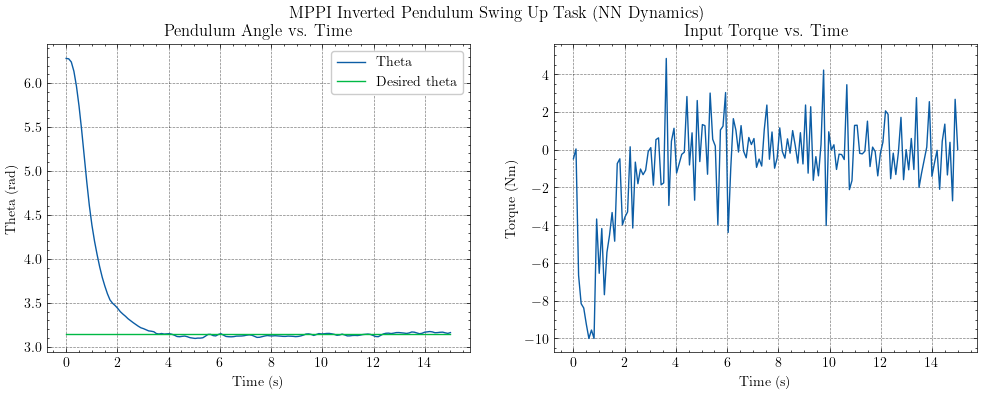

In [124]:
# Plot the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

fig.suptitle("MPPI Inverted Pendulum Swing Up Task (NN Dynamics)")

time = np.linspace(0, simulation_length, n_steps)

ax1.set_title("Pendulum Angle vs. Time")
ax1.plot(time, states[:, 0], label="Theta")
ax1.plot(time, np.repeat(inv_pend_env.desired_state[0], n_steps), label="Desired theta")
ax1.set(xlabel="Time (s)", ylabel="Theta (rad)")
# ax1.set_ylim([-np.pi-0.3, np.pi+0.3])
ax1.legend()

ax2.set_title("Input Torque vs. Time")
ax2.plot(time, controls[:, 0], label="Input torque")
ax2.set(xlabel="Time (s)", ylabel="Torque (Nm)")

fig.savefig("swingup_task.png")

## Online Learning Example
Let's change the inertial properties of the inverted pendulum system and continuously train the dynamics model on newly collected data.

In [148]:
dt = 1 / 10

inv_pend_env = InvertedPendulum(
    initial_state=np.array([0, 0]),
    m=0.5,     # kg
    l=0.5,     # m
    b=0.1,   # ?
    g=-9.81, # m / s^2
    dt=dt    # s
)

inv_pend_env.desired_state = np.array([np.radians(180), 0])

In [151]:
# Set up simulation parameters
simulation_length = 24  # s
n_steps = int((1 / dt) * simulation_length)

# Create lists to store control sequence and state sequences for MPPI runs
controls, states = np.empty((n_steps, inv_pend_env.nu)), np.empty((n_steps, inv_pend_env.nx))

# Set up online learning parameters
online_lr = 0.01
retrain_iters = 1

nn_model = tf.keras.models.load_model(availible_models[idx])

def train_online(x, y):
    nn_model.fit(
        x, y, verbose=0,
        epochs=1, batch_size=len(x)
    )

def init_new_data():
    new_examples = np.empty((retrain_iters, inv_pend_env.nx + inv_pend_env.nu))
    new_labels = np.empty((retrain_iters, inv_pend_env.nx // 2))
    
    return new_examples, new_labels

def label_from_states(prev_state, curr_state):
    acceleration = (curr_state[inv_pend_env.nx // 2:] - prev_state[inv_pend_env.nx // 2:]) / inv_pend_env.dt
    return acceleration

new_examples, new_labels = init_new_data()
tf.keras.backend.set_value(nn_model.optimizer.learning_rate, online_lr)

# Begin simulation
current_state = inv_pend_env.initial_state
start_time = perf_counter()

for i in range(0, n_steps):
    prev_state = current_state
    action = inv_pend_env.controller.step(current_state)
    current_state = inv_pend_env.simulator(current_state, action, measurement_noise=False)
    current_state[0] %= (2 * np.pi)
    
    states[i] = current_state
    controls[i] = action
    
    new_examples[i % retrain_iters] = np.hstack((prev_state, action))
    new_labels[i % retrain_iters] = label_from_states(prev_state, current_state)
    
    # Retrain if current time step is a retrain step
    if i % retrain_iters == 0 and i > 0:
        train_online(new_examples, new_labels)
        new_examples, new_labels = init_new_data()
        

print("Elapsed time: {:.5f} s".format(perf_counter() - start_time))

Elapsed time: 16.29922 s


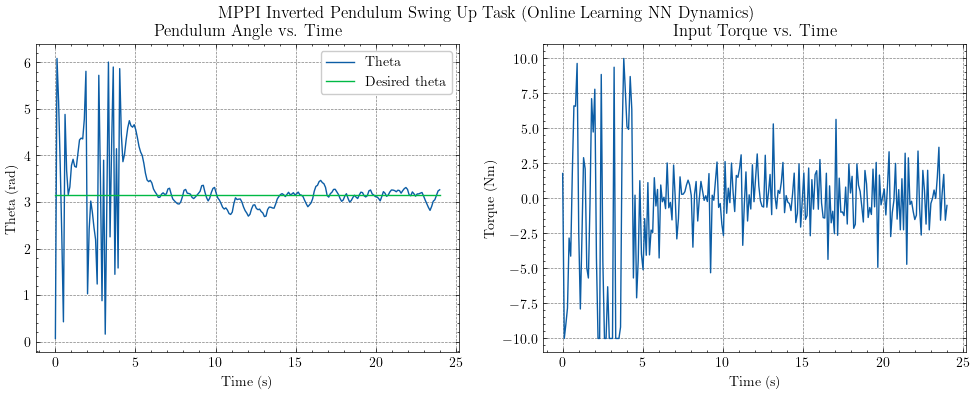

In [152]:
# Plot the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

fig.suptitle("MPPI Inverted Pendulum Swing Up Task (Online Learning NN Dynamics)")

time = np.linspace(0, simulation_length, n_steps)

ax1.set_title("Pendulum Angle vs. Time")
ax1.plot(time, states[:, 0], label="Theta")
ax1.plot(time, np.repeat(inv_pend_env.desired_state[0], n_steps), label="Desired theta")
ax1.set(xlabel="Time (s)", ylabel="Theta (rad)")
ax1.legend()

ax2.set_title("Input Torque vs. Time")
ax2.plot(time, controls[:, 0], label="Input torque")
ax2.set(xlabel="Time (s)", ylabel="Torque (Nm)")

fig.savefig("swingup_task_oll.png")